In [0]:
!pip install nltk
!pip install -r rouge/requirements.txt
!pip install rouge-score
!pip install bert-extractive-summarizer
!pip install torch
from pyspark import SparkFiles
from pyspark.sql import SparkSession
import pandas as pd
import numpy
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import math
from operator import attrgetter
from collections import namedtuple,Counter
from rouge_score import rouge_scorer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
url = "https://bigdatamxk200102.s3.amazonaws.com/articles1.csv"
num_docs = 10
summary_length = 3

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-91e7b167-f91f-48a6-b72f-78847a78021b/bin/python -m pip install --upgrade pip' command.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'rouge/requirements.txt'
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-91e7b167-f91f-48a6-b72f-78847a78021b/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-91e7b167-f91f-48a6-b72f-78847a78021b/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-91e7b167-f91f-48a6-b72f-78847a78021b/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-91e7b167-f91f-48a6-b72f-78847a78021b/bin/python -m pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to /root/n

In [0]:
class svd_class:
    def __init__(self):
        self.epsilon = 1e-10
        
    def svd_decomposition_helper(self, tf_mat):
        prev_v = None
        r,c = tf_mat.shape
        min_shape = min(r,c)
        vector_unn = [numpy.random.normal(0, 1) for i in range(min_shape)]
        norm_val = 0
        for i in vector_unn:
            norm_val += i*i
        curr_v =  [i / math.sqrt(norm_val) for i in vector_unn]
        prev_v = curr_v
        tf_mat_new = numpy.dot(tf_mat.T, tf_mat) if r > c else numpy.dot(tf_mat, tf_mat.T)
        while abs(numpy.dot(curr_v, prev_v)) < 1 - self.epsilon:
            prev_v = curr_v
            curr_v = numpy.dot(tf_mat_new, prev_v)
            curr_v = currentV / norm(curr_v)
        return curr_v

    def calculate_u_v_s(self, m1, m2):
        x = self.svd_decomposition_helper(m1)  
        x_unnor = numpy.dot(m2, x)
        s = numpy.linalg.norm(x_unnor)  
        y = x_unnor / s
        return x,s,y
    
    def svd_main(self, tf_mat, concepts=None):
        tf_mat = numpy.array(tf_mat)
        svd_values = []
        r,c = tf_mat.shape
        if not concepts:
            concepts = min(r,c)
        for i in range(concepts):
            dec_mat = numpy.array(tf_mat)
            for u, s, v in svd_values[:i]:
                dec_mat -= s * numpy.outer(u, v)
            if r > c:
                v, s, u = self.calculate_u_v_s(dec_mat, tf_mat)
            else:
                u, s, v = self.calculate_u_v_s(dec_mat, tf_mat.T) 
            svd_values.append((u, s, v))
        u, s, v = [numpy.array(x) for x in zip(*svd_values)]
        return u.T, s, v

class preprocess:
    def tokenize_to_words(self, data):
        lemmatizer = WordNetLemmatizer()    
        sentences = data[1].split('.')
        res = []
        for sent in sentences:
            #Ignore sentences with less number of words or characters
            if len(sent) < 6:
                continue
            tokens = sent.split(" ")
            if len(tokens) <= 3:
                continue
            tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens if w.lower() not in _stopwords]
            tokens = [w for w in tokens if len(w) > 1]
            res.append(tokens)
        return res

    def preprocess(self, text):
        text = ' '.join([w.strip() for w in text.split() if len(w) > 0])
        text = ''.join([re.sub("[!@#$%^&*()\[\]{};:,/-<>?\|`~=_+“”]", "", i) for i in text])
        text = ''.join(text.replace("Mr.","Mr"))
        text = ''.join(text.replace("Mrs.","Mrs"))
        text = re.sub(r"(\s[a-zA-Z0-9][.])", "", text)
        return text

    def tokenize_to_sentences(self, data):
        sentences = data[1].split('.')
        res = []
        for sent in sentences:
            sent = " ".join(sent.split(" ")).strip()
            #Ignore sentences with less number of words or characters
            if len(sent) < 6:
                continue
            if len(sent.split(" ")) <= 3:
                continue
            res.append(sent)
        return res

class doc_term_matrix:
    def compute_idf(self, total_docs, freq_doc):
        return numpy.log10(numpy.reciprocal(freq_doc) * total_docs)
        
    def compute_doc_term_matrix(self, tokens):
        tokens_count = tokens.map(lambda x: Counter(x))
        unique_vocab = tokens_count.flatMap(lambda x: x)
        unique_vocab = list(set((unique_vocab.collect())))
        broadcast_unique = sc.broadcast(unique_vocab)
        dfvector = tokens_count.map(lambda x: [1.0 if (x.get(w, 0) > 0) else 0.0 for w in broadcast_unique.value] ).reduce(lambda x, y: numpy.array(x) + numpy.array(y))
        tf = tokens_count.map(lambda x: [x.get(w, 0) for w in broadcast_unique.value] ) #.sortByKey()
        return dfvector, tf

    
class CountSent(object):
    def __init__(self, value):
        self.val = value

    def __call__(self, series):
        if isinstance(self.val, (bytes, str,)):
            if self.val.endswith("%"):
                percent = int(self.val[:-1])
                count = max(1, len(series)*percent // 100)
                return series[:count]
            else:
                return series[:int(self.val)]
        elif isinstance(self.val, (int, float)):
            return series[:int(self.val)]
        
        
class extract_summary:
    def __init__(self):
        self.min_dims = 3
        self.red_ratio = 1/1
        self.sent_info = namedtuple("sent_info", ("sentence", "order", "ranking",))
        
    def compute_ranks(self, S, VT):
        dimens = max(self.min_dims, int(len(S)*self.red_ratio ))
        S_pow = tuple(s**2 if i < dimens else 0.0 for i, s in enumerate(S))
        ranks = []
        for col in VT.T:
            rank = sum(s*vT**2 for s, vT in zip(S_pow, col))
            rank = math.sqrt(rank)
            ranks.append(rank)
        return ranks

    def extract_sentences(self, sentences, count, rating):
        rate = rating
        if isinstance(rating, dict):
            rate = lambda s: rating[s]
        out_ = (self.sent_info(sent, index, rate(sent)) for index, sent in enumerate(sentences))
        out_ = sorted(out_, key = attrgetter("ranking"), reverse=True)
        if not isinstance(count, CountSent):
            count = CountSent(count)
        out_ = count(out_)
        out_ = sorted(out_, key=attrgetter("order"))
        return ' '.join(tuple(i.sentence for i in out_))

if __name__ == "__main__":
    spark = SparkSession.builder.appName("Summarization").getOrCreate()
    sc = spark.sparkContext
    _stopwords = stopwords.words('english')
    df = pd.read_csv(url)
    df = spark.createDataFrame(df)
    display(df)
    summary_article_map = df.select('id','title','content')
    text_data = df.select('id','content').limit(num_docs).rdd
    pre = preprocess()
    term_matrix = doc_term_matrix()
    svd_decompose = svd_class()
    get_summ = extract_summary()
    text_data = text_data.map(lambda x: (x[0],pre.preprocess(x[1])))
    generated_summaries = []
    for data in text_data.collect():
        tokens = sc.parallelize(pre.tokenize_to_words(data))
        sentences = sc.parallelize(pre.tokenize_to_sentences(data))
        dfvector, tf_new = term_matrix.compute_doc_term_matrix(tokens)
        tfmatrix = tf_new.collect()
        tfmatrix = numpy.array(numpy.transpose(tfmatrix))
        idf_vec = term_matrix.compute_idf(len(tfmatrix), dfvector)
        idf_vec = numpy.array(numpy.transpose(idf_vec))
        idf_vec = numpy.reshape(idf_vec, (-1,1))
        tfidf_matrix = tfmatrix * idf_vec
        U, S, VT = svd_decompose.svd_main(tfidf_matrix)
        ranks = get_summ.compute_ranks(S, VT)
        ranks = iter(ranks)
        summ = get_summ.extract_sentences(sentences.collect(), summary_length, lambda s: next(ranks))
        generated_summaries.append(summ)
    generated_summaries

Unnamed: 0 id title publication author date year month url content 0 17283 House Republicans Fret About Winning Their Health Care Suit - The New York Times New York Times Carl Hulse 2016-12-31 2016.0 12.0 null WASHINGTON — Congressional Republicans have a new fear when it comes to their health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for and Americans, handing House Republicans a big victory on issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law, angering conservative voters who have been demanding an end to the law for years. In another twist, Donald J. Trump’s administration, worried about preserving executive branch prerogatives, could choose to fight its Republican allies in the House on some central questions in the dispute. Eager to avoid an ugly political pileup, Republicans on Capitol Hill and the Trump transition team are gaming out how to handle the lawsuit, which, after the election, has been put in limbo until at least late February by the United States Court of Appeals for the District of Columbia Circuit. They are not yet ready to divulge their strategy. “Given that this pending litigation involves the Obama administration and Congress, it would be inappropriate to comment,” said Phillip J. Blando, a spokesman for the Trump transition effort. “Upon taking office, the Trump administration will evaluate this case and all related aspects of the Affordable Care Act. ” In a potentially decision in 2015, Judge Rosemary M. Collyer ruled that House Republicans had the standing to sue the executive branch over a spending dispute and that the Obama administration had been distributing the health insurance subsidies, in violation of the Constitution, without approval from Congress. The Justice Department, confident that Judge Collyer’s decision would be reversed, quickly appealed, and the subsidies have remained in place during the appeal. In successfully seeking a temporary halt in the proceedings after Mr. Trump won, House Republicans last month told the court that they “and the ’s transition team currently are discussing potential options for resolution of this matter, to take effect after the ’s inauguration on Jan. 20, 2017. ” The suspension of the case, House lawyers said, will “provide the and his future administration time to consider whether to continue prosecuting or to otherwise resolve this appeal. ” Republican leadership officials in the House acknowledge the possibility of “cascading effects” if the payments, which have totaled an estimated $13 billion, are suddenly stopped. Insurers that receive the subsidies in exchange for paying costs such as deductibles and for eligible consumers could race to drop coverage since they would be losing money. Over all, the loss of the subsidies could destabilize the entire program and cause a lack of confidence that leads other insurers to seek a quick exit as well. Anticipating that the Trump administration might not be inclined to mount a vigorous fight against the House Republicans given the ’s dim view of the health care law, a team of lawyers this month sought to intervene in the case on behalf of two participants in the health care program. In their request, the lawyers predicted that a deal between House Republicans and the new administration to dismiss or settle the case “will 

In [0]:
from summarizer import Summarizer
model = Summarizer('distilbert-base-uncased', hidden=[-1,-2], hidden_concat=True)
gold_summaries = []
for text in df.select('content').limit(num_docs).collect():
    gold_summaries.append(model(text.content, num_sentences=summary_length))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [0]:
def calc_rouge_scores(pred_summaries, gold_summaries, keys=['rouge1', 'rouge2', 'rougeL'], use_stemmer=True):
    scorer = rouge_scorer.RougeScorer(keys, use_stemmer= use_stemmer)
    n = len(gold_summaries)
    scores = [scorer.score(pred_summaries[j], gold_summaries[j]) for j in range(n)] 
    dict_scores={}                                                            
    dict_lists = {}
    l = len(scores)
    for key in keys:
        precision_list = [scores[i][key][0] for i in range(l)]
        recall_list = [scores[i][key][1] for i in range(l)]
        f1_list = [scores[i][key][2] for i in range(l)]
        
        avg_precision = numpy.mean(precision_list)
        avg_recall = numpy.mean(recall_list)
        avg_f1 = numpy.mean(f1_list)

        dict_results = {'recall': avg_recall, 'precision': avg_precision, 'f1': avg_f1}
        dict_results_list = {'recall': recall_list, 'precision': precision_list, 'f1': f1_list}
        dict_scores[key] = dict_results
        dict_lists[key] = dict_results_list
    return dict_scores, dict_lists

res_scores, res_lists = calc_rouge_scores(generated_summaries, gold_summaries)

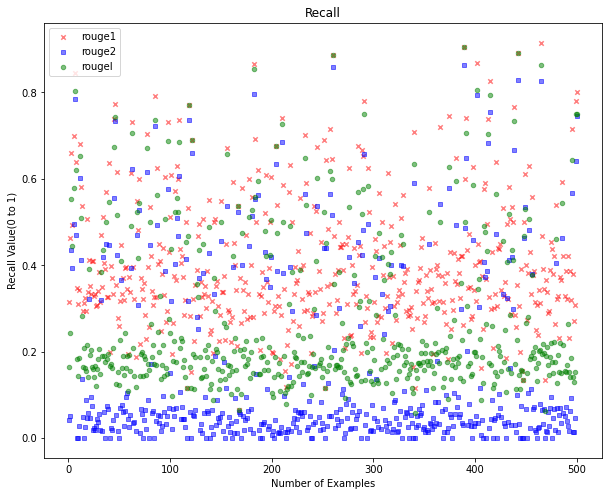

In [0]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8)
x = [i for i in range(1,501)]
a = res_lists['rouge1']['recall']
b = res_lists['rouge2']['recall']
c = res_lists['rougeL']['recall']
plt.scatter(x, a, s=20, c='r', marker='x', alpha=0.5, label = 'rouge1')
plt.scatter(x, b, s=15, c='b', marker='s', alpha=0.5, label = 'rouge2')
plt.scatter(x, c, s=20, c='g', alpha=0.5, label = 'rougel')
plt.legend(loc='upper left')
plt.xlabel('Number of Examples') 
plt.ylabel('Recall Value(0 to 1)') 
plt.title("Recall")
plt.show()

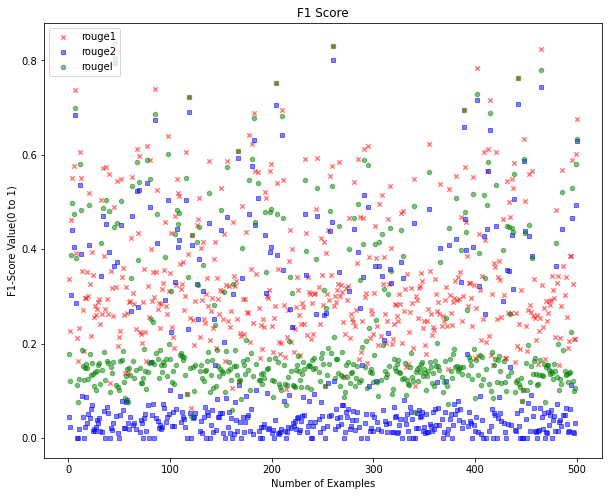

In [0]:
plt.rcParams["figure.figsize"] = (10,8)
x = [i for i in range(1,501)]
a = res_lists['rouge1']['f1']
b = res_lists['rouge2']['f1']
c = res_lists['rougeL']['f1']
plt.scatter(x, a, s=20, c='r', marker='x', alpha=0.5, label = 'rouge1')
plt.scatter(x, b, s=15, c='b', marker='s', alpha=0.5, label = 'rouge2')
plt.scatter(x, c, s=20, c='g', alpha=0.5, label = 'rougel')
plt.legend(loc='upper left')
plt.xlabel('Number of Examples') 
plt.ylabel('F1-Score Value(0 to 1)') 
plt.title("F1 Score")
plt.show()

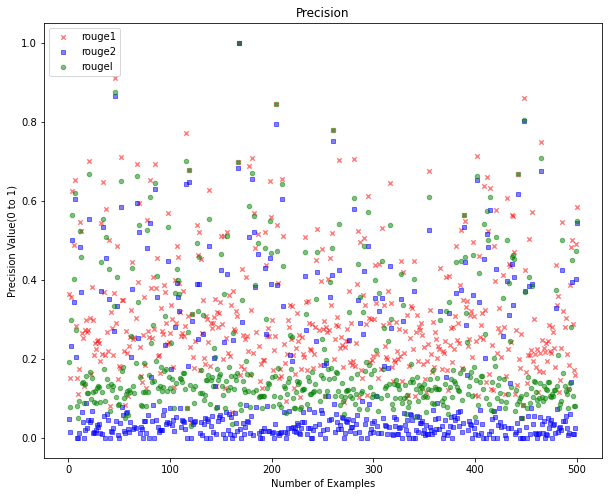

In [0]:
plt.rcParams["figure.figsize"] = (10,8)
x = [i for i in range(1,501)]
a = res_lists['rouge1']['precision']
b = res_lists['rouge2']['precision']
c = res_lists['rougeL']['precision']
plt.scatter(x, a, s=20, c='r', marker='x', alpha=0.5, label = 'rouge1')
plt.scatter(x, b, s=15, c='b', marker='s', alpha=0.5, label = 'rouge2')
plt.scatter(x, c, s=20, c='g', alpha=0.5, label = 'rougel')
plt.legend(loc='upper left')
plt.xlabel('Number of Examples') 
plt.ylabel('Precision Value(0 to 1)') 
plt.title("Precision")
plt.show()